## Figures for analysis of the immune dataset
This notebook reproduces Figures S4D-E, S5A, S5E


In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import palettable

In [19]:
import os
import pandas as pd
import re
import numpy as np
import glob
from pathlib import Path
from scipy import sparse
from copy import deepcopy
import pickle


<h3> Load data </h3>

In [8]:
out_dir = '../out.immune.060121/'

In [9]:
### Can be downloaded at https://data.humantumoratlas.org/
adata = sc.read(out_dir + 'adata.immune.010920.h5ad')


Only considering the two last: ['.010920', '.h5ad'].
Only considering the two last: ['.010920', '.h5ad'].


In [22]:
sclc_dir = '../out.immune.SCLC_samples_only.060121/'

In [24]:
adata_sclc = sc.read(sclc_dir + 'adata.immune.SCLC_samples_only.010920.h5ad')

Only considering the two last: ['.010920', '.h5ad'].
Only considering the two last: ['.010920', '.h5ad'].


### S4D

In [23]:
adata.obs['treatment_categorized'] = adata.obs.treatment.astype(str)
adata.obs.loc[adata.obs.treatment_categorized.str.contains('Immunotherapy'),'treatment_categorized'] = 'IO_ever'
adata.obs.loc[adata.obs.treatment_categorized.str.contains('Platinum Doublet'),'treatment_categorized'] = 'Chemo_1L'
adata.obs.treatment_categorized = adata.obs.treatment_categorized.astype(str).astype('category')

In [24]:
### Can be downloaded at https://data.humantumoratlas.org/
cd45_composition = pd.read_excel('/data/peer/calcifer/SCLC_atlas/version.010920/HTA.metadata/HTA.metadata.populationcomposition.xlsx')
cd45_composition.index = cd45_composition['Column1']
adata.obs['batch'] = np.array(adata.obs['batch'].copy())
adata.obs['batch'][adata.obs['batch'].isin(['RU1108a_Bambanker_Frozen',
                                             'RU1108a_RPMI',
                                             'RU1108a_Bambanker'])] = 'RU1108a_RPMI'
sample_covariates = adata.obs.groupby('batch')[['treatment_categorized','histo','tissue','histology_subtype']].agg(lambda x: pd.Series.mode(x)[0])

cd45_composition['CD45+'][cd45_composition['CD45+']=="Ahsley's"] = 0 # Remove LUAD samples without Flow Sorting information
infiltration = pd.DataFrame(cd45_composition['CD45+']).loc[[i[0] for i in adata.obs.groupby('batch')['histology_subtype'].value_counts().index]]
infiltration = infiltration.loc[~infiltration.index.duplicated(),:]
infiltration['subtype'] = np.array([i[1] for i in adata.obs.groupby('batch')['histology_subtype'].value_counts().index])
infiltration['CD45+'] = infiltration['CD45+'].astype(float)

infiltration['treatment'] = sample_covariates['treatment_categorized'].loc[infiltration.index]
infiltration['tissue'] = sample_covariates['tissue'].loc[infiltration.index]


/home/gaov/anaconda2/envs/py36-sc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/gaov/anaconda2/envs/py36-sc/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
infiltration = infiltration.drop('RU1170g_Freeze-Sort')

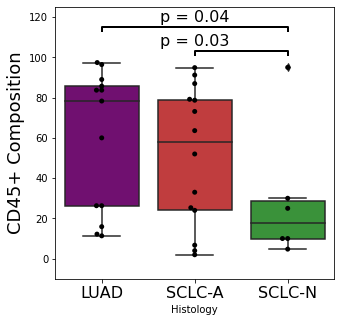

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [5,5]
sns.boxplot(y = 'CD45+', x = 'subtype', data = infiltration.loc[((infiltration['CD45+']>0) ),:],
           order = ['LUAD','SCLC-A','SCLC-N'], palette = ['purple','#D62728','#2CA02C','#1F77B4']
           )
sns.swarmplot(y = 'CD45+', x = 'subtype', data = infiltration.loc[((infiltration['CD45+']>0) ),:],
           order = ['LUAD','SCLC-A','SCLC-N'], 
              color = 'black'
             )
plt.ylabel('CD45+ Composition', fontsize = 18)
plt.xlabel('Histology', fontsize = 10)
plt.xticks(fontsize = 16)
plt.ylim(-10,125)

plt.text(1, 116, "p = "+str(0.04), ha='center', va='bottom',fontsize=16)
plt.plot([0,0,2,2,], [113,115,115,113], lw=2, color = 'black')
plt.text(1, 104, "p = "+str(0.03), ha='center', va='bottom',fontsize=16)
plt.plot([1,1,2,2,], [101,103,103,101], lw=2, color = 'black')


In [11]:
import scipy
scipy.stats.mannwhitneyu(infiltration.loc[((infiltration['CD45+']>0)),:]['CD45+'][
    infiltration.loc[((infiltration['CD45+']>0)),:]['subtype']=='LUAD'],infiltration.loc[((infiltration['CD45+']>0)),:]['CD45+'][
    infiltration.loc[((infiltration['CD45+']>0)),:]['subtype']=='SCLC-N'])


MannwhitneyuResult(statistic=19.0, pvalue=0.04340063114475036)

In [22]:
import scipy
scipy.stats.mannwhitneyu(infiltration.loc[((infiltration['CD45+']>0)),:]['CD45+_res'][
    infiltration.loc[((infiltration['CD45+']>0)),:]['subtype']=='SCLC-A'],infiltration.loc[((infiltration['CD45+']>0)),:]['CD45+_res'][
    infiltration.loc[((infiltration['CD45+']>0)),:]['subtype']=='SCLC-N'])


MannwhitneyuResult(statistic=19.0, pvalue=0.031693527379010614)

### S4E

In [105]:
temp = pd.DataFrame(np.array([['ASCL1+\nNEUROD1-','ASCL1+\nNEUROD1-','ASCL1+\nNEUROD1-','ASCL1+\nNEUROD1-','ASCL1+\nNEUROD1-',
                               'ASCL1+\nNEUROD1+','ASCL1+\nNEUROD1+','ASCL1+\nNEUROD1+','ASCL1+\nNEUROD1+','ASCL1+\nNEUROD1+','ASCL1+\nNEUROD1+'],
                    [43.6,13.7,85.7,88.7,72.5,25.6,31.8,61.2,21.1,6.95,2.51]]).T, 
                    columns = ['subtype','CD45+'])
temp['CD45+'] = np.array(temp['CD45+']).astype(float)

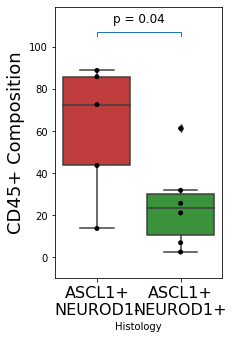

In [106]:
plt.rcParams['figure.figsize'] = [3,5]
sns.boxplot(y = 'CD45+', x = 'subtype', data = temp,
           order = ['ASCL1+\nNEUROD1-','ASCL1+\nNEUROD1+'], palette = ['#D62728','#2CA02C']
           )
sns.swarmplot(y = 'CD45+', x = 'subtype', data = temp,
           order = ['ASCL1+\nNEUROD1-','ASCL1+\nNEUROD1+'], 
              color = 'black'
             )
plt.ylabel('CD45+ Composition', fontsize = 18)
plt.xlabel('Histology', fontsize = 10)
plt.xticks(fontsize = 16)
plt.ylim(-10,119)
plt.text(0.5, 110, "p = "+str(0.04), ha='center', va='bottom',fontsize=12)
plt.plot([0,0,1,1,], [105,107,107,105], lw=1)


In [109]:
import scipy
scipy.stats.mannwhitneyu(temp['CD45+'][
    temp['subtype']=='ASCL1+\nNEUROD1-'],temp['CD45+'][
    temp['subtype']=='ASCL1+\nNEUROD1+'])


MannwhitneyuResult(statistic=5.0, pvalue=0.04141871257940315)

###  S5A

In [6]:
import palettable

In [7]:
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(['B cell', 'Myeloid', 'NK','T cells','Mast', 'Plasma cell']) 


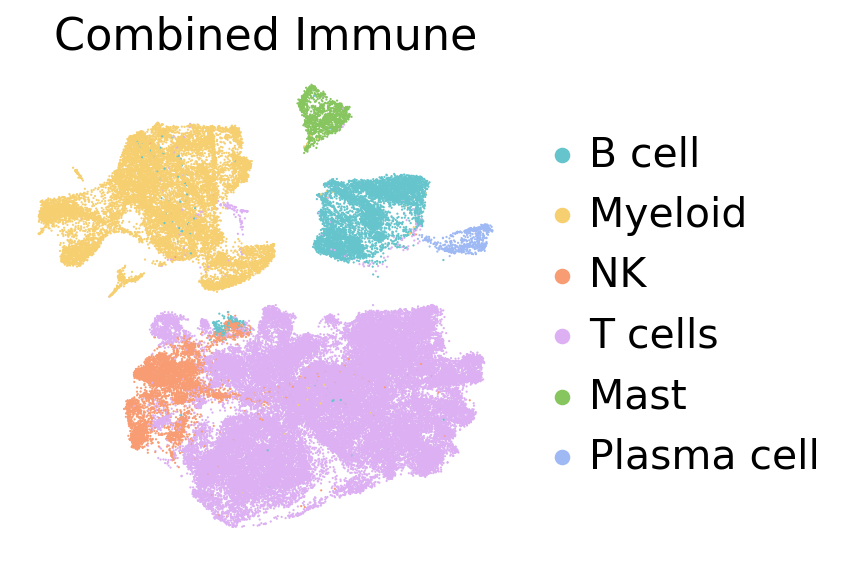

In [10]:

sc.pl.umap(
    adata, 
    color= 'cell_type',
    ncols=2, size=4,
    palette= palettable.cartocolors.qualitative.Pastel_6.mpl_colors, 
    legend_fontoutline=2, title = 'Combined Immune' 
    frameon=False
)

### S5E

In [28]:
from typing import Mapping, Sequence
from matplotlib import cm, colors

vega_20 = list(map(colors.to_hex, cm.tab20.colors))
vega_20_scanpy = [
    # dark without grey:
    *vega_20[0:14:2],
    *vega_20[16::2],
    # light without grey:
    *vega_20[1:15:2],
    *vega_20[17::2],
    # manual additions:
    '#ad494a',
    '#8c6d31',
]


In [14]:
def GetCellTypeFraction(clusters_rls, cell_type, order=None):
    #Percentage of sample in each cluster
#     clusters_rls = pd.DataFrame(clusters_rls, index=cell_type.index)
    proportions = pd.DataFrame(index=set(clusters_rls), columns=sorted(list(set(cell_type))))
    for cluster in set(clusters_rls):
        cells = cell_type.index[clusters_rls == cluster]
        for sample in sorted(list(set(cell_type))):
            sample_cells = cell_type.index[cell_type == sample]
            proportions.loc[cluster, sample] = len(cells.intersection(sample_cells)) / len(cells) * 100
    if order != None:
        proportions = proportions.loc[order]
    return proportions


In [15]:
patient_treatment = pd.DataFrame(adata_sclc.obs.groupby('batch')['treatment_categorized'].value_counts())
patient_treatment['treatment_categorized'] = patient_treatment.index.get_level_values(1)

In [16]:
patient_histo_subtype = pd.DataFrame(adata_sclc.obs.groupby('batch')['subtype'].value_counts())
patient_histo_subtype['subtype'] = patient_histo_subtype.index.get_level_values(1)

Text(0.5, 1.0, 'Coarse Immune Cell Type')

/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


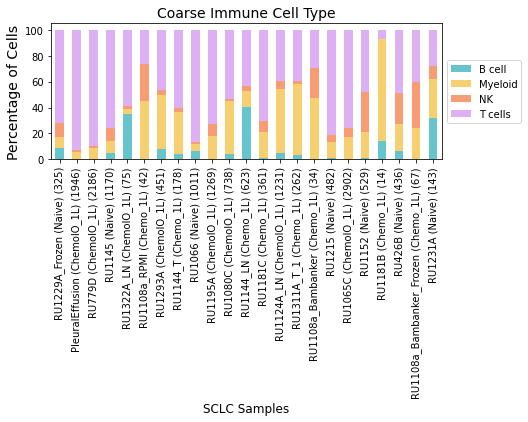

In [20]:
# treatment
proportions_samples = GetCellTypeFraction(np.array(list(adata_sclc.obs['batch'].values)), adata_sclc.obs['cell_type_broad'])


clust_major_rep = proportions_samples.columns[np.argmax(proportions_samples.values, axis=1)]

proportions_samples2 = deepcopy(proportions_samples)
proportions_samples2.index = ['%s (%s) (%s)' % (proportions_samples2.index[i],patient_treatment.loc[proportions_samples2.index[i]].values[0][0],adata_sclc.obs['batch'].value_counts().loc[proportions_samples2.index[i]]) 
                              for i in range(proportions_samples2.shape[0])]
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(7,2.5))

proportions_samples2.plot(kind='bar', stacked=True, ax=axes, colormap=colors.ListedColormap(palettable.cartocolors.qualitative.Pastel_6.mpl_colors[0:4]))
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes.set_xlabel('SCLC Samples', fontsize = 12)
axes.set_ylabel('Percentage of Cells', fontsize = 14)
axes.set_title('Coarse Immune Cell Type', fontsize = 14)



Text(0.5, 1.0, 'Immune Cell Type')

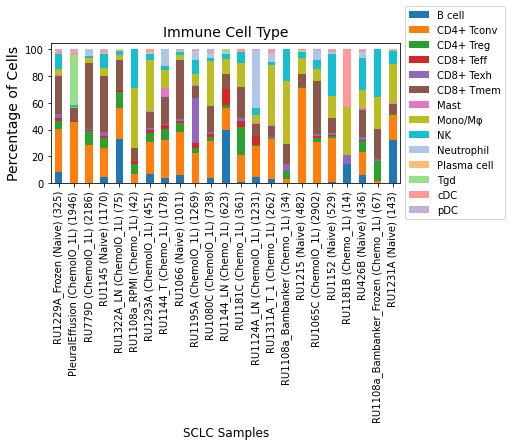

In [29]:
# treatment
proportions_samples = GetCellTypeFraction(np.array(list(adata_sclc.obs['batch'].values)), adata_sclc.obs['cell_type'])


clust_major_rep = proportions_samples.columns[np.argmax(proportions_samples.values, axis=1)]

proportions_samples2 = deepcopy(proportions_samples)
proportions_samples2.index = ['%s (%s) (%s)' % (proportions_samples2.index[i], patient_treatment.loc[proportions_samples2.index[i]].values[0][0], adata_sclc.obs['batch'].value_counts().loc[proportions_samples2.index[i]]) 
                              for i in range(proportions_samples2.shape[0])]
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(7,6))

proportions_samples2.plot(kind='bar', stacked=True, ax=axes, colormap=colors.ListedColormap(vega_20_scanpy[0:14]))
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes.set_xlabel('SCLC Samples', fontsize = 12)
axes.set_ylabel('Percentage of Cells', fontsize = 14)
axes.set_title('Immune Cell Type', fontsize = 14)

